## Create a test and train image generator using the dataset. 

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

data = 'archive/Garbage classification/Garbage classification'
batch_size = 100 # Leads to around 20 batches
target_size = (128, 96) # This is 1/3 the image shape

train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.1,zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test =ImageDataGenerator(rescale=1./255,validation_split=0.1)

train_generator = train.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training'
)

test_generator = test.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Model creation
- parameters allow for different numbers of layers, convolutional filters, learning rate, l1/l2 regularization and dropout.

In [1]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import BatchNormalization

def create_model(learning_rate=1e-3, l1_reg=0.0, l2_reg=0.0, dropout_rate=0.0):
    labels = list(train_generator.class_indices.keys())
    num_classes = len(labels)
    model = models.Sequential()

    model.add(layers.Conv2D(8, (3, 3), padding='same', input_shape=(128, 96, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(8,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2))) 

    model.add(layers.Conv2D(16,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(16,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2))) 

    model.add(layers.Conv2D(32,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2))) 
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    return model



2023-11-27 20:09:57.943693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


After testing different parameters, we chose to apply dropout, batch normalization, and l1/l2 regularization to prevent overfitting. 

Train the model, with parameters as determined to be optimum for the model. Early stopping is applied.

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True)
final_model = create_model(.001, .001, .001, .15)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = final_model.fit(train_generator, epochs=200, validation_data=test_generator, callbacks=[checkpoint, early_stop])

Epoch 1/200
23/23 [==============================] - ETA: 0s - loss: 73.6189 - accuracy: 0.2900
Epoch 1: val_loss improved from inf to 47.57130, saving model to best_model.h5
23/23 [==============================] - 21s 842ms/step - loss: 73.6189 - accuracy: 0.2900 - val_loss: 47.5713 - val_accuracy: 0.2829
Epoch 2/200
23/23 [==============================] - ETA: 0s - loss: 33.4413 - accuracy: 0.3647
Epoch 2: val_loss improved from 47.57130 to 22.04538, saving model to best_model.h5
23/23 [==============================] - 18s 792ms/step - loss: 33.4413 - accuracy: 0.3647 - val_loss: 22.0454 - val_accuracy: 0.1992
Epoch 3/200
23/23 [==============================] - ETA: 0s - loss: 15.5296 - accuracy: 0.4011
Epoch 3: val_loss improved from 22.04538 to 10.69242, saving model to best_model.h5
23/23 [==============================] - 19s 826ms/step - loss: 15.5296 - accuracy: 0.4011 - val_loss: 10.6924 - val_accuracy: 0.1952
Epoch 4/200
23/23 [==============================] - ETA: 0s - 

23/23 [==============================] - ETA: 0s - loss: 1.7830 - accuracy: 0.7153
Epoch 57: val_loss improved from 1.90397 to 1.89641, saving model to best_model.h5
23/23 [==============================] - 19s 804ms/step - loss: 1.7830 - accuracy: 0.7153 - val_loss: 1.8964 - val_accuracy: 0.6693
Epoch 58/200
23/23 [==============================] - ETA: 0s - loss: 1.7717 - accuracy: 0.7192
Epoch 58: val_loss did not improve from 1.89641
23/23 [==============================] - 18s 793ms/step - loss: 1.7717 - accuracy: 0.7192 - val_loss: 2.4757 - val_accuracy: 0.5020
Epoch 59/200
23/23 [==============================] - ETA: 0s - loss: 1.7787 - accuracy: 0.7131
Epoch 59: val_loss did not improve from 1.89641
23/23 [==============================] - 18s 795ms/step - loss: 1.7787 - accuracy: 0.7131 - val_loss: 2.1082 - val_accuracy: 0.5896
Epoch 60/200
23/23 [==============================] - ETA: 0s - loss: 1.7617 - accuracy: 0.7105
Epoch 60: val_loss did not improve from 1.89641
23/23 

23/23 [==============================] - 18s 795ms/step - loss: 1.6817 - accuracy: 0.7302 - val_loss: 2.0177 - val_accuracy: 0.6175
Epoch 87/200
23/23 [==============================] - ETA: 0s - loss: 1.7044 - accuracy: 0.7311
Epoch 87: val_loss did not improve from 1.77461
23/23 [==============================] - 19s 804ms/step - loss: 1.7044 - accuracy: 0.7311 - val_loss: 1.9384 - val_accuracy: 0.6215
Epoch 88/200
23/23 [==============================] - ETA: 0s - loss: 1.6921 - accuracy: 0.7368
Epoch 88: val_loss did not improve from 1.77461
23/23 [==============================] - 19s 801ms/step - loss: 1.6921 - accuracy: 0.7368 - val_loss: 1.8537 - val_accuracy: 0.6494
Epoch 89/200
23/23 [==============================] - ETA: 0s - loss: 1.6769 - accuracy: 0.7434
Epoch 89: val_loss did not improve from 1.77461
23/23 [==============================] - 19s 809ms/step - loss: 1.6769 - accuracy: 0.7434 - val_loss: 1.7978 - val_accuracy: 0.6972
Epoch 90/200
23/23 [====================

In [19]:
# Save model for prediction
import joblib 

filename = 'model1.sav'
joblib.dump(final_model, filename)

['model1.sav']

Found 251 images belonging to 6 classes.
3/3 [==============================] - 1s 220ms/step
Confusion Matrix:
[[34  2  1  2  0  1]
 [ 3 29  6  0 11  1]
 [ 2  5 28  1  4  1]
 [ 4  0  0 52  3  0]
 [ 6  2  3  5 32  0]
 [ 1  2  0  2  1  7]]


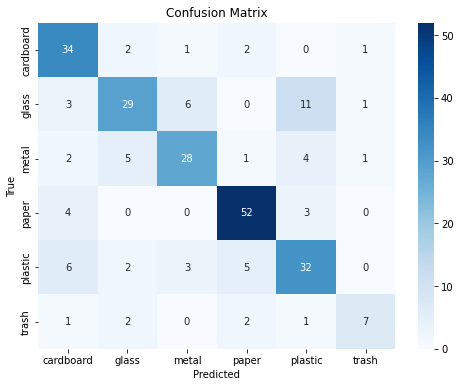

In [21]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

test_set = test.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation',
    shuffle = False
)

predictions = final_model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

confusion_mat = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(confusion_mat)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)

for i, class_label in enumerate(class_labels):
    print(f"Metrics for {class_label}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-score: {f1[i]}\n")

overall_precision = precision_score(true_classes, predicted_classes, average='weighted')
overall_recall = recall_score(true_classes, predicted_classes, average='weighted')
overall_f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Overall Metrics:")
print(f"Weighted Precision: {overall_precision}")
print(f"Weighted Recall: {overall_recall}")
print(f"Weighted F1-score: {overall_f1}")


Metrics for cardboard:
Precision: 0.68
Recall: 0.85
F1-score: 0.7555555555555556

Metrics for glass:
Precision: 0.725
Recall: 0.58
F1-score: 0.6444444444444445

Metrics for metal:
Precision: 0.7368421052631579
Recall: 0.6829268292682927
F1-score: 0.7088607594936709

Metrics for paper:
Precision: 0.8387096774193549
Recall: 0.8813559322033898
F1-score: 0.859504132231405

Metrics for plastic:
Precision: 0.6274509803921569
Recall: 0.6666666666666666
F1-score: 0.6464646464646465

Metrics for trash:
Precision: 0.7
Recall: 0.5384615384615384
F1-score: 0.608695652173913

Overall Metrics:
Weighted Precision: 0.7265420093320915
Weighted Recall: 0.7250996015936255
Weighted F1-score: 0.721760262525505


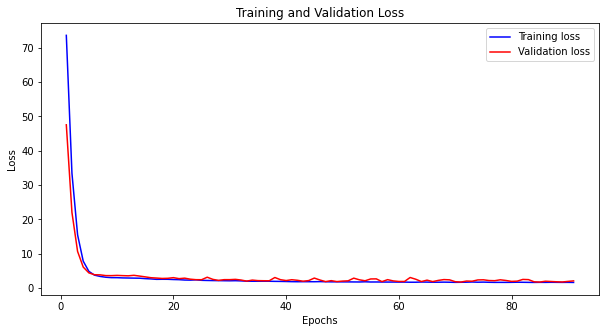

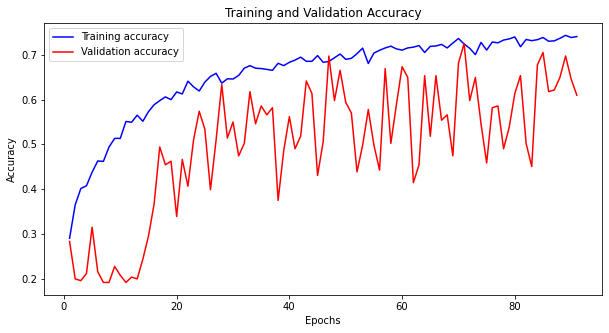

In [29]:
# Plotting training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
